In [20]:
import pandas as pd

df_point5 = pd.read_pickle(f'./E4 results/E4 for analysis/E4.1.1_results_202501142151_all_point5.pkl')
# df_point5_meta = pd.read_pickle(f'./E4 results/E4 for analysis/E4.1.1_results_202501142151_log_all_point5.pkl')

df_point7 = pd.read_pickle(f'./E4 results/E4 for analysis/E4.1.2_results_202501201323_all.pkl')
# df_point7_meta = pd.read_pickle(f'./E4 results/E4 for analysis/results_202501142151_log_all_point5.pkl')

df_point7_z3 = pd.read_pickle(f'./E4 results/E4 for analysis/E4.1.2_results_202501201323_all.pkl')


In [21]:
def one_value_analysis(df, metric='Max Quality',print_outcomes=False):
    
    pivot_df = df.pivot_table(index='Dataset', columns='Algorithm', values=metric)
    if print_outcomes:
        print("Pivoted DataFrame:")
        print(pivot_df)
    
    # Step 2: Initialize counters for outcomes for each comparison.
    # Each will be a dictionary with keys 'Higher', 'Equal', 'Lower'.
    comparison_stats = {
        'BUSPaS vs Beam Search': {'Higher': 0, 'Equal': 0, 'Lower': 0},
        'BUSPaS vs MCTS4DM': {'Higher': 0, 'Equal': 0, 'Lower': 0}
    }
    
    # Step 3: Iterate through each dataset and compare BUSPaS with the others.
    for dataset, row in pivot_df.iterrows():
        # Compare BUSPaS vs Beam Search
        if pd.notna(row.get('BUSPaS')) and pd.notna(row.get('Beam Search')):
            if row['BUSPaS'] > row['Beam Search']:
                comparison_stats['BUSPaS vs Beam Search']['Higher'] += 1
            elif row['BUSPaS'] == row['Beam Search']:
                comparison_stats['BUSPaS vs Beam Search']['Equal'] += 1
            else:
                comparison_stats['BUSPaS vs Beam Search']['Lower'] += 1
    
        # Compare BUSPaS vs MCTS4DM
        if pd.notna(row.get('BUSPaS')) and pd.notna(row.get('MCTS4DM')):
            if row['BUSPaS'] > row['MCTS4DM']:
                comparison_stats['BUSPaS vs MCTS4DM']['Higher'] += 1
            elif row['BUSPaS'] == row['MCTS4DM']:
                comparison_stats['BUSPaS vs MCTS4DM']['Equal'] += 1
            else:
                comparison_stats['BUSPaS vs MCTS4DM']['Lower'] += 1
    
    # Step 4: Organize results into a 2x3 matrix-like DataFrame.
    result_matrix = pd.DataFrame.from_dict(comparison_stats, orient='index')
    result_matrix = result_matrix[['Lower', 'Equal', 'Higher']]  # Ensure column order
    if print_outcomes:
        print("\n2x3 Matrix of Comparison Results:")
        print(result_matrix)
    print(result_matrix.to_latex())
    return pivot_df

def normalize_row(row):
    min_val = row.min()
    max_val = row.max()
    return (row - 0) / (max_val - 0)

import matplotlib.pyplot as plt

def plot_pivot_tables_with_markers(pivot_table_x, pivot_table_y, markers=None, initial_size=100):
    """
    Plots values from two pivot tables as x and y, using different markers and colors for algorithms.

    Args:
        pivot_table_x (pd.DataFrame): The pivot table for x-axis values.
        pivot_table_y (pd.DataFrame): The pivot table for y-axis values.
        markers (list): A list of markers for each algorithm. Defaults to a preset list.
        initial_size (float): The size of the points (default: 100).
    """
    if not pivot_table_x.columns.equals(pivot_table_y.columns):
        raise ValueError("Both pivot tables must have the same columns (Algorithms).")
    if not pivot_table_x.index.equals(pivot_table_y.index):
        raise ValueError("Both pivot tables must have the same index (Datasets).")

    # Default markers if not provided
    if markers is None:
        markers = ['o', 'x', '^', 's', 'd', 'v', 'P', '*', '+', 'H']  # Customize as needed

    # Define plot
    plt.figure(figsize=(10, 8))

    # Plot data for each algorithm
    for idx, algorithm in enumerate(pivot_table_x.columns):
        x_values = pivot_table_x[algorithm].values
        y_values = pivot_table_y[algorithm].values
        marker = markers[idx % len(markers)]  # Cycle through markers if there are more algorithms than markers

        plt.scatter(
            x_values, y_values, label=algorithm, s=initial_size, alpha=0.7, marker=marker
        )

    # Add labels, legend, and title
    plt.xlabel("Normalized Time", fontsize=14)
    plt.ylabel("Normalized Diversity", fontsize=14)
    plt.title("Comparison of Pivot Table Values by Algorithm", fontsize=16)
    plt.legend(title="Algorithms", fontsize=12, title_fontsize=13)
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()
    

from reportlab.graphics import renderPDF
from svglib.svglib import svg2rlg


def save_svg_file():
    # Save a simple SVG manually or use another method to create one
    svg_content = '''
    <svg xmlns="http://www.w3.org/2000/svg" width="200" height="200">
        <circle cx="100" cy="100" r="80" stroke="black" stroke-width="3" fill="red" />
        <text x="50" y="100" font-family="Verdana" font-size="20" fill="white">SVG</text>
    </svg>
    '''
    svg_filename = "./E4 results/figures/time_diversity_log.svg"
    with open(svg_filename, "w") as svg_file:
        svg_file.write(svg_content)
    print(f"SVG file saved as {svg_filename}")
    return svg_filename


def convert_svg_to_pdf(svg_filename):
    # Convert SVG to PDF
    pdf_filename = svg_filename.replace(".svg", ".pdf")
    drawing = svg2rlg(svg_filename)
    renderPDF.drawToFile(drawing, pdf_filename)
    print(f"PDF file saved as {pdf_filename}")
    return pdf_filename


import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_pivot_tables_with_logscale(pivot_table_x, pivot_table_y, markers=None, initial_size=100, 
                                    log_scale=False, title=None, xaxis_label=None, yaxis_label=None):
    """
    Plots values from two pivot tables as x and y, with different markers for algorithms
    and different colors for datasets. Connects points of the same dataset with lines.
    Provides an option for logarithmic scaling of axes. Saves the plot as SVG and PDF.

    Args:
        pivot_table_x (pd.DataFrame): The pivot table for x-axis values.
        pivot_table_y (pd.DataFrame): The pivot table for y-axis values.
        markers (list): A list of markers for each algorithm. Defaults to a preset list.
        initial_size (float): The size of the points (default: 100).
        log_scale (bool): If True, sets x and y axes to logarithmic scale (default: False).
        title (str): Title of the plot.
        xaxis_label (str): Label for the x-axis.
        yaxis_label (str): Label for the y-axis.
    """
    # Check for consistency between pivot tables
    if not pivot_table_x.columns.equals(pivot_table_y.columns):
        raise ValueError("Both pivot tables must have the same columns (Algorithms).")
    if not pivot_table_x.index.equals(pivot_table_y.index):
        raise ValueError("Both pivot tables must have the same index (Datasets).")

    # Default markers if not provided
    if markers is None:
        markers = ['o', 'x', '^', 's', 'd', 'v', 'P', '*', '+', 'H']  # Customize as needed

    # Generate sufficient distinct colors for datasets
    num_datasets = len(pivot_table_x.index)
    cmap = cm.get_cmap('tab20', num_datasets)  # Use a colormap with enough distinct colors
    colors = [cmap(i) for i in range(num_datasets)]

    # Define plot
    plt.figure(figsize=(12, 8))

    # Plot each dataset with its own color
    for idx, dataset in enumerate(pivot_table_x.index):
        color = colors[idx]
        x_values = pivot_table_x.loc[dataset].values
        y_values = pivot_table_y.loc[dataset].values

        # Plot the line connecting points of the same dataset
        plt.plot(
            x_values, y_values, color=color, linestyle='-', linewidth=1, alpha=0.6, label=f"{dataset} (line)"
        )

        # Plot points for each algorithm with unique markers
        for alg_idx, algorithm in enumerate(pivot_table_x.columns):
            plt.scatter(
                x_values[alg_idx], y_values[alg_idx], color=color, s=initial_size,
                marker=markers[alg_idx % len(markers)], label=f"{dataset}-{algorithm}" if idx == 0 else None
            )

    # Set log scale if specified
    if log_scale:
        plt.xscale('log')
        plt.yscale('log')

    # Add labels, legend, and title
    plt.xlabel(xaxis_label, fontsize=14)
    plt.ylabel(yaxis_label, fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(fontsize=6, title="Legend", title_fontsize=8, loc='best', ncol=2)
    plt.grid(True)
    plt.tight_layout()

    # Define the output directory and filenames
    output_dir = './E4 results/figures'
    os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist
    base_filename = f"plot_pivot_tables_{xaxis_label}_{yaxis_label}"
    svg_filename = os.path.join(output_dir, f"{base_filename}.svg")
    pdf_filename = os.path.join(output_dir, f"{base_filename}.pdf")

    # Save the figure as SVG and PDF
    plt.savefig(svg_filename, format="svg")
    plt.savefig(pdf_filename, format="pdf")

    print(f"Plot saved as SVG: {svg_filename}")
    print(f"Plot saved as PDF: {pdf_filename}")

    # Show the plot
    plt.show()
    
    
import numpy as np
from scipy.stats import friedmanchisquare, studentized_range
from math import sqrt

def transform_to_ranks(df, columns):
    """
    Transforms a dataframe with performance columns into a rank matrix suitable for the Friedman test.
    
    Parameters:
    - df: A pandas DataFrame containing dataset results.
    - columns: A list of column names corresponding to the performance of algorithms.
    
    Returns:
    - A numpy array where rows correspond to datasets and columns contain the ranks of algorithms.
    """
    # Extract the relevant columns
    relevant_data = df[columns]
    
    # Handle boolean values: Convert True/False to 1/0
    relevant_data = relevant_data.map(lambda x: 1 if x is True else (0 if x is False else x))
    
    # Convert rows to ranks (lower values = better rank, handle ties)
    ranks = relevant_data.rank(axis=1, method="average", ascending=False).to_numpy()
    
    return np.array(ranks.astype(int))


# Critical values for the Nemenyi test based on Demšar (2006)
nemenyi_critical_values = {
    0.10: {  # Significance level alpha = 0.10
        2: 1.645,
        3: 2.052,
        4: 2.291,
        5: 2.460,
        6: 2.589,
        7: 2.692,
        8: 2.778,
        9: 2.851,
        10: 2.915,
        11: 2.971,
        12: 3.021,
        13: 3.066,
        14: 3.106,
        15: 3.142,
        16: 3.176,
        17: 3.207,
        18: 3.235,
        19: 3.261,
        20: 3.285,
    },
    0.05: {  # Significance level alpha = 0.05
        2: 1.960,
        3: 2.343,
        4: 2.569,
        5: 2.728,
        6: 2.850,
        7: 2.948,
        8: 3.031,
        9: 3.102,
        10: 3.164,
        11: 3.219,
        12: 3.268,
        13: 3.312,
        14: 3.352,
        15: 3.388,
        16: 3.421,
        17: 3.451,
        18: 3.478,
        19: 3.503,
        20: 3.526,
    },
    0.01: {  # Significance level alpha = 0.01
        2: 2.576,
        3: 3.314,
        4: 3.764,
        5: 4.043,
        6: 4.242,
        7: 4.397,
        8: 4.527,
        9: 4.639,
        10: 4.736,
        11: 4.820,
        12: 4.894,
        13: 4.960,
        14: 5.020,
        15: 5.076,
        16: 5.126,
        17: 5.173,
        18: 5.217,
        19: 5.258,
        20: 5.296,
    }
}



def friedman_stat(df, bus_value, bs_value, mc_value, nemenyi_critical_values = nemenyi_critical_values, print_output=False):

    # Step 1: Input data (Ranks for each dataset)
    ranks = transform_to_ranks(df, [bus_value, bs_value, mc_value]) # np.array([
    #     [3, 1, 2, 4],  # Dataset 1
    #     [3, 2, 1, 4],  # Dataset 2
    #     [1, 3, 2, 4],  # Dataset 3
    #     [2, 3, 1, 4],  # Dataset 4
    #     [1, 4, 2, 3],  # Dataset 5
    # ])
    
    # Number of datasets (N) and algorithms (k)
    N, k = ranks.shape
    
    # Step 2: Average ranks
    average_ranks = ranks.mean(axis=0)
    
    # Step 3: Friedman statistic
    friedman_stat, p_value = friedmanchisquare(*ranks.T)
     
    # Iman-Davenport adjustment for small sample sizes
    F_F = ((N - 1) * friedman_stat) / (N * (k - 1) - friedman_stat)
     
    # # Step 4: Nemenyi Test - Critical Difference (CD)
    alpha = 0.05  # Significance level

    q_alpha = nemenyi_critical_values[alpha][k]
    CD = q_alpha * sqrt(k * (k + 1) / (6 * N))

    # Step 5: Pairwise comparisons
    pairwise_differences = np.abs(np.subtract.outer(average_ranks, average_ranks))

    # Check significance of pairwise differences
    significant_pairs = pairwise_differences > CD
    
    results = {
        "Average Ranks": average_ranks,
        "Friedman Statistic": friedman_stat,
        "p-value": p_value,
        "Iman-Davenport F": F_F,
        "Critical Difference (CD)": CD,
        "Pairwise Differences": pairwise_differences,
        "Significant Differences": significant_pairs
    }
    if print_output:
        print('Average ranks (bus,bs,mc)= ', average_ranks.round(3))
        print('Friedman Statistic= ', round(friedman_stat,3))
        print('p-value= ', round(p_value,5))
        print('Iman-Davenport F= ', round(F_F,3))
        print("Critical Difference (CD)= ", round(CD,2))
        print("Pairwise Differences= ", pairwise_differences)
        print("Significant Differences= ", significant_pairs)
    return     'Average ranks (bus,bs,mc)= '+ str(average_ranks.round(3))+' Friedman Statistic= '+ str(round(friedman_stat,3))+' p-value= '+ str(round(p_value,5))+' Iman-Davenport F= '+ str(round(F_F,3))+ " Critical Difference (CD)= "+ str(round(CD,2))+" Pairwise Differences= "+ str(pairwise_differences)+" Significant Differences= " + str(significant_pairs)

## Part 1

This notebook is composed of two parts. The second part is about z=3

In [22]:
print(df_point5['Configuration'][0])
print(' ')
print(df_point7['Configuration'][0])
print(' ')
print(df_point7_z3['Configuration'][0])


{'similarity_treshold': 0.5, 'dataset_selection': 'all', 'd': 3, 'q': 20, 'bins': 5, 'min_cov': 0.05, 'min_coverage_abs': 3, 'correct_for_size': <function no_size_corr at 0x0000017E3FD65A80>, 'comparison_type': 'complement', 'w': 20, 'min_error': 0.01, 'ensure_diversity': True, 'number_of_row_pairs': 50, 'z': 2, 'max_time_minutes': None, 'ucb_type': 'SP-MCTS', 'ucb_params': {}, 'roll_out_strategy': 'direct-freq', 'reward_policy': 'max_path', 'reward_policy_k': 3, 'memory_policy': 'all', 'memory_policy_k_value': 3, 'update_policy': 'max_update', 'update_policy_k': 3}
 
{'similarity_treshold': 0.7, 'dataset_selection': 'all', 'd': 3, 'q': 20, 'bins': 5, 'min_cov': 0.05, 'min_coverage_abs': 3, 'correct_for_size': <function no_size_corr at 0x0000017E3FD65A80>, 'comparison_type': 'complement', 'w': 20, 'min_error': 0.01, 'ensure_diversity': True, 'number_of_row_pairs': 50, 'z': 2, 'max_time_minutes': None, 'ucb_type': 'SP-MCTS', 'ucb_params': {}, 'roll_out_strategy': 'direct-freq', 'reward_

C:\Users\bengelen004\AppData\Local\Temp\ipykernel_14820\3267491928.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df_point5['Configuration'][0])
C:\Users\bengelen004\AppData\Local\Temp\ipykernel_14820\3267491928.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df_point7['Configuration'][0])
C:\Users\bengelen004\AppData\Local\Temp\ipykernel_14820\3267491928.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print

In [23]:
df_reset_point7 = df_point7.reset_index()
df_reset_point7[['Algorithm', 'FloatPart']] = df_reset_point7['index'].str.rsplit(n=1, expand=True)
df_reset_point7.drop(columns=['index', 'FloatPart'], inplace=True)

df_reset_point5 = df_point5.reset_index()
df_reset_point5[['Algorithm', 'FloatPart']] = df_reset_point5['index'].str.rsplit(n=1, expand=True)
df_reset_point5.drop(columns=['index', 'FloatPart'], inplace=True)

df_reset_point7_z3 = df_point7_z3.reset_index()
df_reset_point7_z3[['Algorithm', 'FloatPart']] = df_reset_point7_z3['index'].str.rsplit(n=1, expand=True)
df_reset_point7_z3.drop(columns=['index', 'FloatPart'], inplace=True)

In [24]:
# pivot_max_qual.columns

In [25]:
df_reset_point7_z3

,Dataset,Max Quality,Avg Quality,Max Coverage,Avg Coverage,Subgroups Checked,Time,Ratio n.q.,Time per group,Redundancy,Diversity,Cover Redundancy,Configuration,Result,Algorithm
0,wisconsin,0.865,0.852000,0.108,0.066000,567,6.538537,0.957504,0.012,0.95,0.865218,1.672630,"{'similarity_treshold': 0.7, 'dataset_selectio...","[(0.865218, 0.061855670103092786, 418, [A2 == ...",Beam Search
1,wisconsin,0.865,0.850509,0.108,0.065464,538,7.097081,0.970110,0.013,0.65,5.980409,1.646481,"{'similarity_treshold': 0.7, 'dataset_selectio...","[(0.865218, 0.061855670103092786, [-2.03436 <=...",BUSPaS
2,wisconsin,0.856,0.842000,0.124,0.072000,1080,7.190026,0.945024,0.007,0.95,0.855625,1.625626,"{'similarity_treshold': 0.7, 'dataset_selectio...","[(0.85562503, 0.061855670103092786, 492, [A11 ...",MCTS4DM
3,cpu,0.700,0.666000,0.201,0.107000,170,21.555539,0.296215,0.127,0.95,0.699613,1.558051,"{'similarity_treshold': 0.7, 'dataset_selectio...","[(0.69961315, 0.098388671875, 129, [A6 == '-0....",Beam Search
4,cpu,0.517,0.511795,0.202,0.163086,7,13.318614,0.898267,1.903,0.00,3.582564,0.740961,"{'similarity_treshold': 0.7, 'dataset_selectio...","[(0.51732653, 0.2015380859375, [-0.70097 <= A4...",BUSPaS
5,cpu,0.684,0.634000,0.203,0.113000,205,13.396821,0.083010,0.065,0.95,0.684218,1.500763,"{'similarity_treshold': 0.7, 'dataset_selectio...","[(0.6842184, 0.1649169921875, 54, [A5 == '-0.8...",MCTS4DM
6,voting,1.214,1.185000,0.071,0.055000,2586,124.793681,0.976273,0.048,0.95,1.213951,1.439873,"{'similarity_treshold': 0.7, 'dataset_selectio...","[(1.2139509, 0.05128205128205128, 1850, [Migra...",Beam Search
7,voting,1.214,1.193507,0.074,0.058120,40040,1054.468111,0.978498,0.026,0.40,14.348391,1.540194,"{'similarity_treshold': 0.7, 'dataset_selectio...","[(1.2139509, 0.05128205128205128, [77.6 <= Dut...",BUSPaS
8,voting,1.211,1.162000,0.068,0.056000,19503,1054.468678,0.980860,0.054,0.95,1.211393,1.345299,"{'similarity_treshold': 0.7, 'dataset_selectio...","[(1.2113935, 0.05128205128205128, 3333, [Migra...",MCTS4DM
9,student_math,0.419,0.395000,0.084,0.058000,1218,10.245697,0.934468,0.008,0.95,0.418766,1.648676,"{'similarity_treshold': 0.7, 'dataset_selectio...","[(0.41876644, 0.053164556962025315, 998, [fail...",Beam Search


In [26]:
pivot_max_qual = one_value_analysis(df_reset_point5, metric='Max Quality')
print(friedman_stat(pivot_max_qual, 'BUSPaS', 'Beam Search', 'MCTS4DM', nemenyi_critical_values = nemenyi_critical_values, print_output=False))

print(pivot_max_qual.round(3).astype(str).to_latex())
normalized_pivot_max_qual = pivot_max_qual.apply(normalize_row, axis=1)


\begin{tabular}{lrrr}
\toprule
 & Lower & Equal & Higher \\
\midrule
BUSPaS vs Beam Search & 8 & 10 & 0 \\
BUSPaS vs MCTS4DM & 6 & 5 & 7 \\
\bottomrule
\end{tabular}

Average ranks (bus,bs,mc)= [2.056 1.278 2.333] Friedman Statistic= 13.435 p-value= 0.00121 Iman-Davenport F= 10.121 Critical Difference (CD)= 0.78 Pairwise Differences= [[0.         0.77777778 0.27777778]
 [0.77777778 0.         1.05555556]
 [0.27777778 1.05555556 0.        ]] Significant Differences= [[False False False]
 [False False  True]
 [False  True False]]
\begin{tabular}{llll}
\toprule
Algorithm & BUSPaS & Beam Search & MCTS4DM \\
Dataset &  &  &  \\
\midrule
Australia & 2.882 & 2.882 & 2.882 \\
Brazil & 2.688 & 2.688 & 2.688 \\
France & 1.832 & 1.832 & 1.805 \\
Germany & 4.413 & 4.413 & 4.413 \\
India & 1.319 & 1.385 & 1.385 \\
Indonesia & 2.069 & 2.069 & 1.8 \\
Netherlands & 3.563 & 3.563 & 3.563 \\
South Korea & 1.647 & 1.647 & 1.633 \\
cpu & 0.517 & 0.7 & 0.684 \\
ecoli & 0.768 & 0.768 & 0.768 \\
elevators & 

In [27]:
0.05/16

0.003125

In [28]:
pivot_diversity_point5 = one_value_analysis(df_reset_point5, metric='Diversity')
print(friedman_stat(pivot_diversity_point5, 'BUSPaS', 'Beam Search', 'MCTS4DM', nemenyi_critical_values = nemenyi_critical_values, print_output=False))
print(pivot_diversity_point5.round(3).astype(str).to_latex())
normalized_pivot_diversity_point5 = pivot_diversity_point5.apply(normalize_row, axis=1)
# normalized_pivot_diversity_point5

\begin{tabular}{lrrr}
\toprule
 & Lower & Equal & Higher \\
\midrule
BUSPaS vs Beam Search & 1 & 0 & 17 \\
BUSPaS vs MCTS4DM & 0 & 0 & 18 \\
\bottomrule
\end{tabular}

Average ranks (bus,bs,mc)= [1.056 2.5   2.444] Friedman Statistic= 24.111 p-value= 1e-05 Iman-Davenport F= 34.477 Critical Difference (CD)= 0.78 Pairwise Differences= [[0.         1.44444444 1.38888889]
 [1.44444444 0.         0.05555556]
 [1.38888889 0.05555556 0.        ]] Significant Differences= [[False  True  True]
 [ True False False]
 [ True False False]]
\begin{tabular}{llll}
\toprule
Algorithm & BUSPaS & Beam Search & MCTS4DM \\
Dataset &  &  &  \\
\midrule
Australia & 34.783 & 5.093 & 8.166 \\
Brazil & 21.153 & 8.357 & 9.825 \\
France & 21.383 & 3.382 & 7.269 \\
Germany & 34.31 & 7.952 & 12.306 \\
India & 10.799 & 4.004 & 8.224 \\
Indonesia & 18.846 & 6.987 & 9.027 \\
Netherlands & 32.099 & 9.616 & 13.095 \\
South Korea & 16.381 & 4.65 & 8.2 \\
cpu & 3.583 & 0.7 & 0.684 \\
ecoli & 4.298 & 1.395 & 1.385 \\
eleva

In [29]:
pivot_diversity_point7 = one_value_analysis(df_reset_point7, metric='Diversity')
print(friedman_stat(pivot_diversity_point7, 'BUSPaS', 'Beam Search', 'MCTS4DM', nemenyi_critical_values = nemenyi_critical_values, print_output=False))
print(pivot_diversity_point7.round(3).astype(str).to_latex())

normalized_pivot_diversity_point7 = pivot_diversity_point7.apply(normalize_row, axis=1)


\begin{tabular}{lrrr}
\toprule
 & Lower & Equal & Higher \\
\midrule
BUSPaS vs Beam Search & 0 & 0 & 18 \\
BUSPaS vs MCTS4DM & 0 & 0 & 18 \\
\bottomrule
\end{tabular}

Average ranks (bus,bs,mc)= [1.    2.389 2.5  ] Friedman Statistic= 27.886 p-value= 0.0 Iman-Davenport F= 58.423 Critical Difference (CD)= 0.78 Pairwise Differences= [[0.         1.38888889 1.5       ]
 [1.38888889 0.         0.11111111]
 [1.5        0.11111111 0.        ]] Significant Differences= [[False  True  True]
 [ True False False]
 [ True False False]]
\begin{tabular}{llll}
\toprule
Algorithm & BUSPaS & Beam Search & MCTS4DM \\
Dataset &  &  &  \\
\midrule
Australia & 38.098 & 5.093 & 5.093 \\
Brazil & 21.331 & 8.357 & 6.517 \\
France & 29.307 & 3.382 & 4.694 \\
Germany & 40.078 & 7.952 & 20.496 \\
India & 12.128 & 4.004 & 5.084 \\
Indonesia & 22.376 & 8.406 & 8.406 \\
Netherlands & 38.504 & 11.986 & 14.506 \\
South Korea & 16.864 & 4.65 & 8.2 \\
cpu & 3.583 & 0.7 & 0.684 \\
ecoli & 6.35 & 1.395 & 1.385 \\
elevat

In [30]:
pivot_redundancy_point5 = one_value_analysis(df_reset_point5, metric='Redundancy')
print(friedman_stat(pivot_redundancy_point5, 'BUSPaS', 'Beam Search', 'MCTS4DM', nemenyi_critical_values = nemenyi_critical_values, print_output=False))
print(pivot_redundancy_point5.round(3).astype(str).to_latex())


\begin{tabular}{lrrr}
\toprule
 & Lower & Equal & Higher \\
\midrule
BUSPaS vs Beam Search & 17 & 0 & 1 \\
BUSPaS vs MCTS4DM & 18 & 0 & 0 \\
\bottomrule
\end{tabular}

Average ranks (bus,bs,mc)= [2.944 1.111 1.556] Friedman Statistic= 28.646 p-value= 0.0 Iman-Davenport F= 66.222 Critical Difference (CD)= 0.78 Pairwise Differences= [[0.         1.83333333 1.38888889]
 [1.83333333 0.         0.44444444]
 [1.38888889 0.44444444 0.        ]] Significant Differences= [[False  True  True]
 [ True False False]
 [ True False False]]
\begin{tabular}{llll}
\toprule
Algorithm & BUSPaS & Beam Search & MCTS4DM \\
Dataset &  &  &  \\
\midrule
Australia & 0.2 & 0.9 & 0.8 \\
Brazil & 0.4 & 0.8 & 0.75 \\
France & 0.35 & 0.9 & 0.75 \\
Germany & 0.45 & 0.9 & 0.8 \\
India & 0.55 & 0.85 & 0.65 \\
Indonesia & 0.35 & 0.8 & 0.7 \\
Netherlands & 0.3 & 0.85 & 0.7 \\
South Korea & 0.4 & 0.85 & 0.7 \\
cpu & 0.0 & 0.95 & 0.95 \\
ecoli & 0.6 & 0.9 & 0.9 \\
elevators & 0.25 & 0.95 & 0.95 \\
large_economies & 0.3 & 0

In [31]:
pivot_redundancy_point7 = one_value_analysis(df_reset_point7, metric='Redundancy')
print(friedman_stat(pivot_redundancy_point7, 'BUSPaS', 'Beam Search', 'MCTS4DM', nemenyi_critical_values = nemenyi_critical_values, print_output=False))
print(pivot_redundancy_point7.round(3).astype(str).to_latex())


\begin{tabular}{lrrr}
\toprule
 & Lower & Equal & Higher \\
\midrule
BUSPaS vs Beam Search & 18 & 0 & 0 \\
BUSPaS vs MCTS4DM & 18 & 0 & 0 \\
\bottomrule
\end{tabular}

Average ranks (bus,bs,mc)= [3.    1.111 1.389] Friedman Statistic= 31.651 p-value= 0.0 Iman-Davenport F= 123.715 Critical Difference (CD)= 0.78 Pairwise Differences= [[0.         1.88888889 1.61111111]
 [1.88888889 0.         0.27777778]
 [1.61111111 0.27777778 0.        ]] Significant Differences= [[False  True  True]
 [ True False False]
 [ True False False]]
\begin{tabular}{llll}
\toprule
Algorithm & BUSPaS & Beam Search & MCTS4DM \\
Dataset &  &  &  \\
\midrule
Australia & 0.1 & 0.9 & 0.9 \\
Brazil & 0.4 & 0.8 & 0.85 \\
France & 0.1 & 0.9 & 0.85 \\
Germany & 0.35 & 0.9 & 0.6 \\
India & 0.5 & 0.85 & 0.8 \\
Indonesia & 0.2 & 0.75 & 0.75 \\
Netherlands & 0.15 & 0.8 & 0.7 \\
South Korea & 0.4 & 0.85 & 0.7 \\
cpu & 0.0 & 0.95 & 0.95 \\
ecoli & 0.4 & 0.9 & 0.9 \\
elevators & 0.1 & 0.95 & 0.95 \\
large_economies & 0.25 & 0.

In [32]:
pivot_time_point7 = one_value_analysis(df_reset_point7, metric='Time')
print(friedman_stat(pivot_time_point7, 'BUSPaS', 'Beam Search', 'MCTS4DM', nemenyi_critical_values = nemenyi_critical_values, print_output=False))
print(pivot_time_point7.round(3).astype(str).to_latex())
normalized_pivot_time_point7 = pivot_time_point7.apply(normalize_row, axis=1)


\begin{tabular}{lrrr}
\toprule
 & Lower & Equal & Higher \\
\midrule
BUSPaS vs Beam Search & 14 & 0 & 4 \\
BUSPaS vs MCTS4DM & 18 & 0 & 0 \\
\bottomrule
\end{tabular}

Average ranks (bus,bs,mc)= [2.778 1.444 1.778] Friedman Statistic= 17.333 p-value= 0.00017 Iman-Davenport F= 15.786 Critical Difference (CD)= 0.78 Pairwise Differences= [[0.         1.33333333 1.        ]
 [1.33333333 0.         0.33333333]
 [1.         0.33333333 0.        ]] Significant Differences= [[False  True  True]
 [ True False False]
 [ True False False]]
\begin{tabular}{llll}
\toprule
Algorithm & BUSPaS & Beam Search & MCTS4DM \\
Dataset &  &  &  \\
\midrule
Australia & 4.364 & 8.561 & 4.364 \\
Brazil & 3.07 & 4.012 & 3.07 \\
France & 3.665 & 5.278 & 3.666 \\
Germany & 4.968 & 6.808 & 4.969 \\
India & 3.404 & 6.295 & 4.392 \\
Indonesia & 1.507 & 4.545 & 1.575 \\
Netherlands & 3.257 & 4.843 & 3.258 \\
South Korea & 2.394 & 7.435 & 2.395 \\
cpu & 13.319 & 21.556 & 13.397 \\
ecoli & 0.234 & 1.306 & 0.239 \\
elevat

In [33]:
pivot_time_point7 = one_value_analysis(df_reset_point7, metric='Subgroups Checked')
print(friedman_stat(pivot_time_point7, 'BUSPaS', 'Beam Search', 'MCTS4DM', nemenyi_critical_values = nemenyi_critical_values, print_output=False))
print(pivot_time_point7.round(3).astype(str).to_latex())
normalized_pivot_time_point7 = pivot_time_point7.apply(normalize_row, axis=1)


\begin{tabular}{lrrr}
\toprule
 & Lower & Equal & Higher \\
\midrule
BUSPaS vs Beam Search & 9 & 0 & 9 \\
BUSPaS vs MCTS4DM & 9 & 0 & 9 \\
\bottomrule
\end{tabular}

Average ranks (bus,bs,mc)= [2. 2. 2.] Friedman Statistic= 0.0 p-value= 1.0 Iman-Davenport F= 0.0 Critical Difference (CD)= 0.78 Pairwise Differences= [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]] Significant Differences= [[False False False]
 [False False False]
 [False False False]]
\begin{tabular}{llll}
\toprule
Algorithm & BUSPaS & Beam Search & MCTS4DM \\
Dataset &  &  &  \\
\midrule
Australia & 136.0 & 244.0 & 186.0 \\
Brazil & 328.0 & 192.0 & 263.0 \\
France & 187.0 & 204.0 & 195.0 \\
Germany & 277.0 & 339.0 & 86.0 \\
India & 314.0 & 217.0 & 168.0 \\
Indonesia & 211.0 & 198.0 & 239.0 \\
Netherlands & 404.0 & 269.0 & 188.0 \\
South Korea & 276.0 & 198.0 & 148.0 \\
cpu & 7.0 & 170.0 & 205.0 \\
ecoli & 71.0 & 299.0 & 82.0 \\
elevators & 23.0 & 150.0 & 190.0 \\
large_economies & 97.0 & 162.0 & 255.0 \\
student_math & 11165.0 & 12

In [34]:
pivot_time_point5 = one_value_analysis(df_reset_point5, metric='Time')
print(friedman_stat(pivot_time_point5, 'BUSPaS', 'Beam Search', 'MCTS4DM', nemenyi_critical_values = nemenyi_critical_values, print_output=False))
normalized_pivot_time_point5 = pivot_time_point5.apply(normalize_row, axis=1)
# normalized_pivot_time_point5

\begin{tabular}{lrrr}
\toprule
 & Lower & Equal & Higher \\
\midrule
BUSPaS vs Beam Search & 13 & 0 & 5 \\
BUSPaS vs MCTS4DM & 18 & 0 & 0 \\
\bottomrule
\end{tabular}

Average ranks (bus,bs,mc)= [2.722 1.556 1.722] Friedman Statistic= 14.333 p-value= 0.00077 Iman-Davenport F= 11.246 Critical Difference (CD)= 0.78 Pairwise Differences= [[0.         1.16666667 1.        ]
 [1.16666667 0.         0.16666667]
 [1.         0.16666667 0.        ]] Significant Differences= [[False  True  True]
 [ True False False]
 [ True False False]]


In [35]:
pivot_redundancy_point7 = one_value_analysis(df_reset_point7, metric='Cover Redundancy')
print(friedman_stat(pivot_redundancy_point7, 'BUSPaS', 'Beam Search', 'MCTS4DM', nemenyi_critical_values = nemenyi_critical_values, print_output=False))
print(pivot_redundancy_point7.round(3).astype(str).to_latex())
# pivot_redundancy_point7

\begin{tabular}{lrrr}
\toprule
 & Lower & Equal & Higher \\
\midrule
BUSPaS vs Beam Search & 15 & 0 & 3 \\
BUSPaS vs MCTS4DM & 6 & 0 & 12 \\
\bottomrule
\end{tabular}

Average ranks (bus,bs,mc)= [2.167 1.222 2.611] Friedman Statistic= 18.111 p-value= 0.00012 Iman-Davenport F= 17.211 Critical Difference (CD)= 0.78 Pairwise Differences= [[0.         0.94444444 0.44444444]
 [0.94444444 0.         1.38888889]
 [0.44444444 1.38888889 0.        ]] Significant Differences= [[False  True False]
 [ True False  True]
 [False  True False]]
\begin{tabular}{llll}
\toprule
Algorithm & BUSPaS & Beam Search & MCTS4DM \\
Dataset &  &  &  \\
\midrule
Australia & 1.06 & 1.32 & 1.137 \\
Brazil & 0.961 & 0.999 & 1.5 \\
France & 1.186 & 1.404 & 0.714 \\
Germany & 0.594 & 0.491 & 0.307 \\
India & 0.833 & 1.111 & 0.634 \\
Indonesia & 0.661 & 1.165 & 1.02 \\
Netherlands & 1.267 & 1.315 & 0.953 \\
South Korea & 0.977 & 1.212 & 0.599 \\
cpu & 0.741 & 1.558 & 1.501 \\
ecoli & 0.604 & 0.651 & 0.242 \\
elevators & 

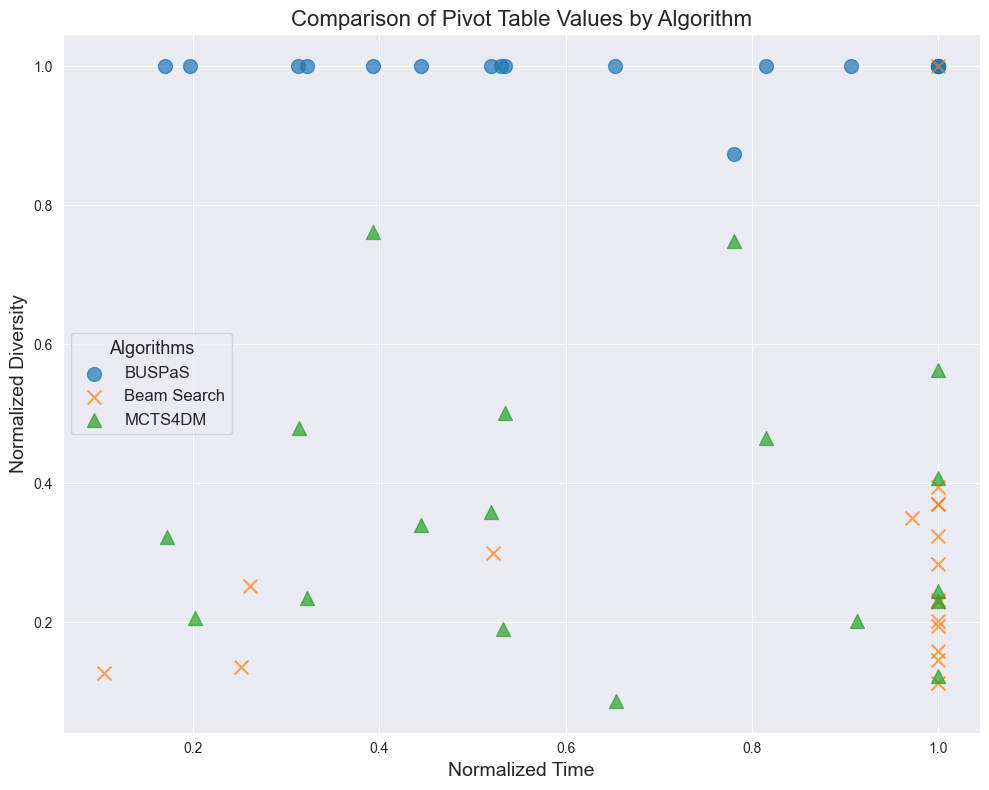

In [36]:
plot_pivot_tables_with_markers(normalized_pivot_time_point5, normalized_pivot_diversity_point5)

In [37]:


svg_file = save_svg_file()
convert_svg_to_pdf(svg_file)

SVG file saved as ./E4 results/figures/time_diversity_log.svg
PDF file saved as ./E4 results/figures/time_diversity_log.pdf


'./E4 results/figures/time_diversity_log.pdf'

In [38]:
print(pivot_time_point5)

Algorithm             BUSPaS  Beam Search      MCTS4DM
Dataset                                               
Australia           3.550174    11.030484     3.551081
Brazil              3.073855     3.772038     3.073857
France              3.446117     7.753326     3.446649
Germany             4.970598     9.570531     4.970615
India               3.322744     8.444967     3.322858
Indonesia           1.496917     4.781939     1.497595
Netherlands         5.553012     2.897877     5.553612
South Korea         2.432502     4.551416     2.432934
cpu                11.303201    21.304727    11.340568
ecoli               0.231594     1.364275     0.234893
elevators          44.696799    68.411163    44.734900
large_economies    95.341398    92.609793    95.341611
student_math       41.639047    10.448005    41.646267
student_por        40.958580    10.691998    40.960721
sushi              23.025795    29.514496    23.026680
voting           1222.455642   127.871522  1222.456387
wine      

C:\Users\bengelen004\AppData\Local\Temp\ipykernel_14820\607225318.py:156: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_datasets)  # Use a colormap with enough distinct colors


Plot saved as SVG: ./E4 results/figures\plot_pivot_tables_time_diversity.svg
Plot saved as PDF: ./E4 results/figures\plot_pivot_tables_time_diversity.pdf


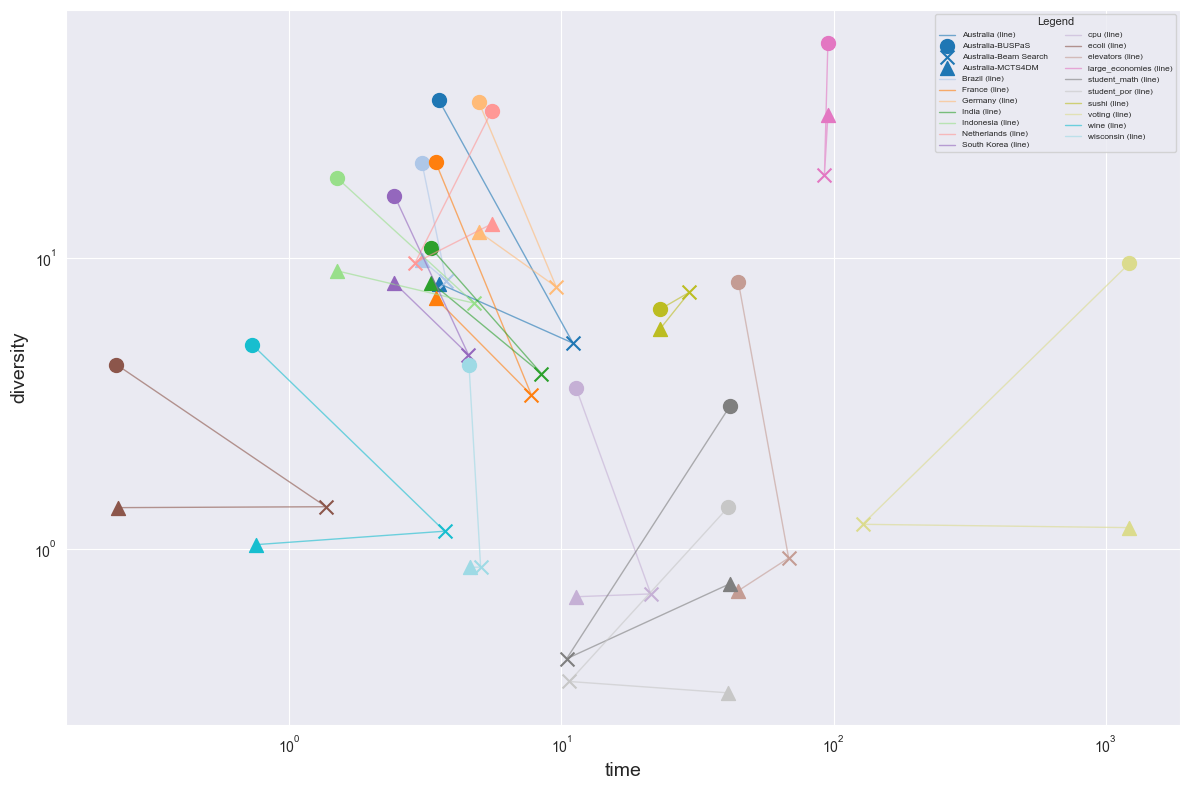

In [39]:
plot_pivot_tables_with_logscale(pivot_time_point5, pivot_diversity_point5, log_scale=True,xaxis_label='time',yaxis_label='diversity')

C:\Users\bengelen004\AppData\Local\Temp\ipykernel_14820\607225318.py:156: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_datasets)  # Use a colormap with enough distinct colors


Plot saved as SVG: ./E4 results/figures\plot_pivot_tables_time_max quality.svg
Plot saved as PDF: ./E4 results/figures\plot_pivot_tables_time_max quality.pdf


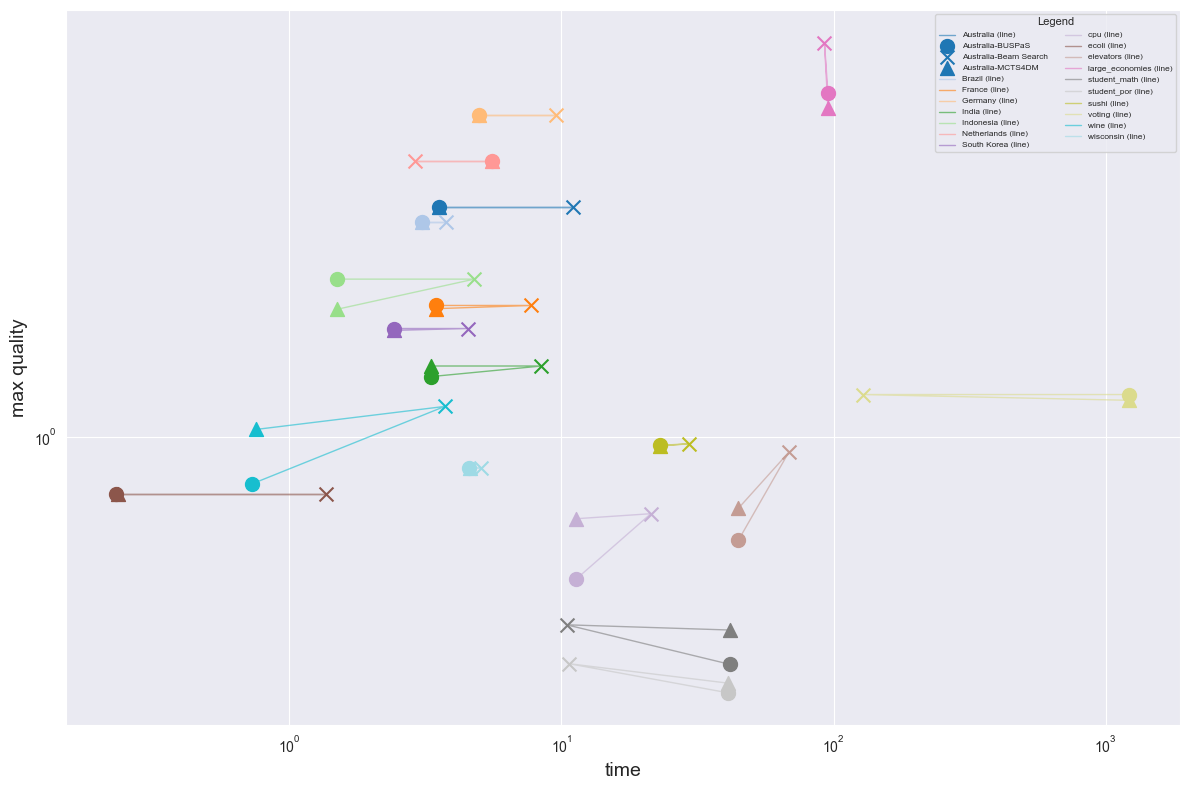

In [40]:
plot_pivot_tables_with_logscale(pivot_time_point5, pivot_max_qual, log_scale=True,xaxis_label='time',yaxis_label='max quality')

C:\Users\bengelen004\AppData\Local\Temp\ipykernel_14820\607225318.py:156: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_datasets)  # Use a colormap with enough distinct colors


Plot saved as SVG: ./E4 results/figures\plot_pivot_tables_time_redundancy.svg
Plot saved as PDF: ./E4 results/figures\plot_pivot_tables_time_redundancy.pdf


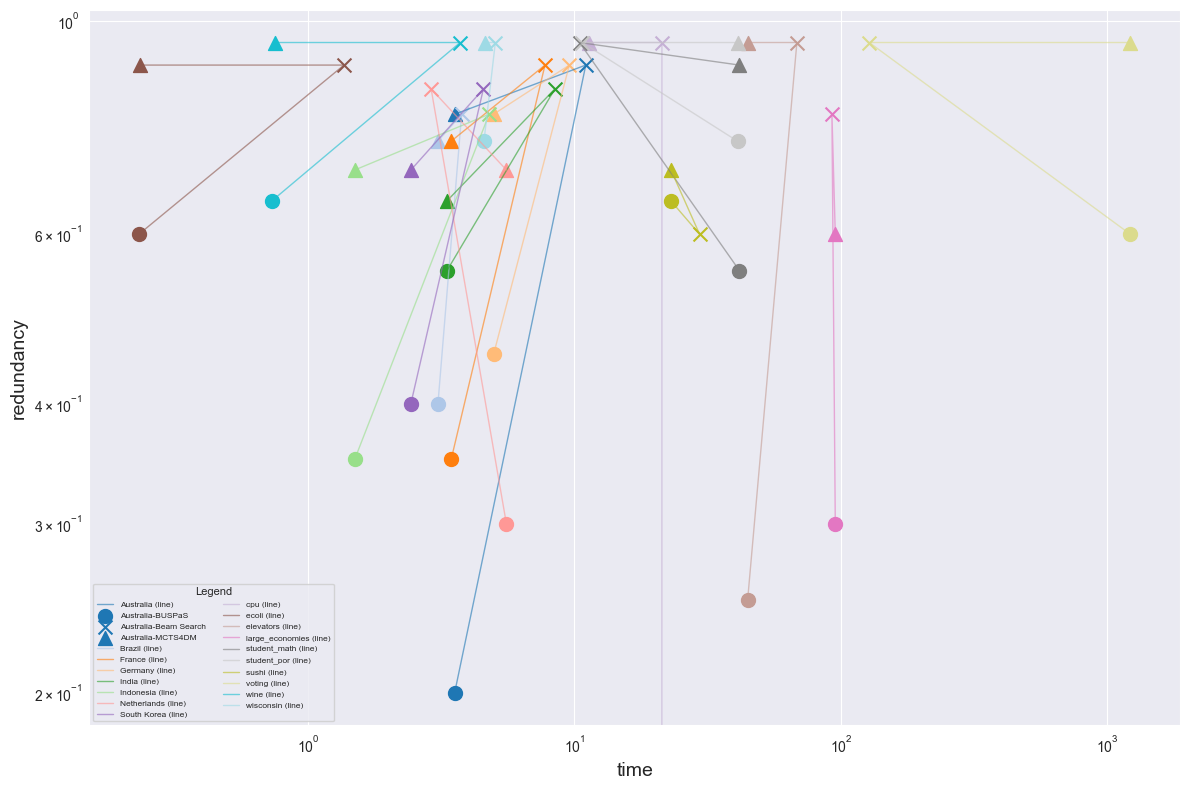

In [41]:
plot_pivot_tables_with_logscale(pivot_time_point5, pivot_redundancy_point5, log_scale=True,xaxis_label='time',yaxis_label='redundancy')

## Part 2

In [26]:
df_reset_point7_z3

,Dataset,Max Quality,Avg Quality,Max Coverage,Avg Coverage,Subgroups Checked,Time,Ratio n.q.,Time per group,Redundancy,Diversity,Cover Redundancy,Configuration,Result,Algorithm
0,wisconsin,0.865,0.852000,0.108,0.066000,567,6.538537,0.957504,0.012,0.95,0.865218,1.672630,"{'similarity_treshold': 0.7, 'dataset_selectio...","[(0.865218, 0.061855670103092786, 418, [A2 == ...",Beam Search
1,wisconsin,0.865,0.850509,0.108,0.065464,538,7.097081,0.970110,0.013,0.65,5.980409,1.646481,"{'similarity_treshold': 0.7, 'dataset_selectio...","[(0.865218, 0.061855670103092786, [-2.03436 <=...",BUSPaS
2,wisconsin,0.856,0.842000,0.124,0.072000,1080,7.190026,0.945024,0.007,0.95,0.855625,1.625626,"{'similarity_treshold': 0.7, 'dataset_selectio...","[(0.85562503, 0.061855670103092786, 492, [A11 ...",MCTS4DM
3,cpu,0.700,0.666000,0.201,0.107000,170,21.555539,0.296215,0.127,0.95,0.699613,1.558051,"{'similarity_treshold': 0.7, 'dataset_selectio...","[(0.69961315, 0.098388671875, 129, [A6 == '-0....",Beam Search
4,cpu,0.517,0.511795,0.202,0.163086,7,13.318614,0.898267,1.903,0.00,3.582564,0.740961,"{'similarity_treshold': 0.7, 'dataset_selectio...","[(0.51732653, 0.2015380859375, [-0.70097 <= A4...",BUSPaS
5,cpu,0.684,0.634000,0.203,0.113000,205,13.396821,0.083010,0.065,0.95,0.684218,1.500763,"{'similarity_treshold': 0.7, 'dataset_selectio...","[(0.6842184, 0.1649169921875, 54, [A5 == '-0.8...",MCTS4DM
6,voting,1.214,1.185000,0.071,0.055000,2586,124.793681,0.976273,0.048,0.95,1.213951,1.439873,"{'similarity_treshold': 0.7, 'dataset_selectio...","[(1.2139509, 0.05128205128205128, 1850, [Migra...",Beam Search
7,voting,1.214,1.193507,0.074,0.058120,40040,1054.468111,0.978498,0.026,0.40,14.348391,1.540194,"{'similarity_treshold': 0.7, 'dataset_selectio...","[(1.2139509, 0.05128205128205128, [77.6 <= Dut...",BUSPaS
8,voting,1.211,1.162000,0.068,0.056000,19503,1054.468678,0.980860,0.054,0.95,1.211393,1.345299,"{'similarity_treshold': 0.7, 'dataset_selectio...","[(1.2113935, 0.05128205128205128, 3333, [Migra...",MCTS4DM
9,student_math,0.419,0.395000,0.084,0.058000,1218,10.245697,0.934468,0.008,0.95,0.418766,1.648676,"{'similarity_treshold': 0.7, 'dataset_selectio...","[(0.41876644, 0.053164556962025315, 998, [fail...",Beam Search


In [17]:
pivot_max_qual = one_value_analysis(df_reset_point7_z3, metric='Max Quality')
print(pivot_max_qual.round(3).astype(str).to_latex())
normalized_pivot_max_qual = pivot_max_qual.apply(normalize_row, axis=1)

\begin{tabular}{lrrr}
\toprule
 & Lower & Equal & Higher \\
\midrule
BUSPaS vs Beam Search & 8 & 10 & 0 \\
BUSPaS vs MCTS4DM & 7 & 6 & 5 \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
Algorithm & BUSPaS & Beam Search & MCTS4DM \\
Dataset &  &  &  \\
\midrule
Australia & 2.882 & 2.882 & 2.882 \\
Brazil & 2.688 & 2.688 & 2.688 \\
France & 1.832 & 1.832 & 1.805 \\
Germany & 4.413 & 4.413 & 4.413 \\
India & 1.319 & 1.385 & 1.385 \\
Indonesia & 2.069 & 2.069 & 2.069 \\
Netherlands & 3.563 & 3.563 & 3.563 \\
South Korea & 1.647 & 1.647 & 1.633 \\
cpu & 0.517 & 0.7 & 0.684 \\
ecoli & 0.768 & 0.768 & 0.768 \\
elevators & 0.619 & 0.929 & 0.734 \\
large_economies & 4.893 & 6.173 & 6.173 \\
student_math & 0.349 & 0.419 & 0.409 \\
student_por & 0.306 & 0.35 & 0.334 \\
sushi & 0.96 & 0.967 & 0.957 \\
voting & 1.214 & 1.214 & 1.211 \\
wine & 0.804 & 1.149 & 1.127 \\
wisconsin & 0.865 & 0.865 & 0.856 \\
\bottomrule
\end{tabular}



In [18]:
pivot_time = one_value_analysis(df_reset_point7_z3, metric='Time')
print(pivot_max_qual.round(3).astype(str).to_latex())
normalized_pivot_time = pivot_max_qual.apply(normalize_row, axis=1)

\begin{tabular}{lrrr}
\toprule
 & Lower & Equal & Higher \\
\midrule
BUSPaS vs Beam Search & 14 & 0 & 4 \\
BUSPaS vs MCTS4DM & 18 & 0 & 0 \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
Algorithm & BUSPaS & Beam Search & MCTS4DM \\
Dataset &  &  &  \\
\midrule
Australia & 2.882 & 2.882 & 2.882 \\
Brazil & 2.688 & 2.688 & 2.688 \\
France & 1.832 & 1.832 & 1.805 \\
Germany & 4.413 & 4.413 & 4.413 \\
India & 1.319 & 1.385 & 1.385 \\
Indonesia & 2.069 & 2.069 & 2.069 \\
Netherlands & 3.563 & 3.563 & 3.563 \\
South Korea & 1.647 & 1.647 & 1.633 \\
cpu & 0.517 & 0.7 & 0.684 \\
ecoli & 0.768 & 0.768 & 0.768 \\
elevators & 0.619 & 0.929 & 0.734 \\
large_economies & 4.893 & 6.173 & 6.173 \\
student_math & 0.349 & 0.419 & 0.409 \\
student_por & 0.306 & 0.35 & 0.334 \\
sushi & 0.96 & 0.967 & 0.957 \\
voting & 1.214 & 1.214 & 1.211 \\
wine & 0.804 & 1.149 & 1.127 \\
wisconsin & 0.865 & 0.865 & 0.856 \\
\bottomrule
\end{tabular}



In [23]:
pivot_diversity = one_value_analysis(df_reset_point7_z3, metric='Diversity')
print(pivot_max_qual.round(3).astype(str).to_latex())
normalized_pivot_diversity = pivot_max_qual.apply(normalize_row, axis=1)

\begin{tabular}{lrrr}
\toprule
 & Lower & Equal & Higher \\
\midrule
BUSPaS vs Beam Search & 0 & 0 & 18 \\
BUSPaS vs MCTS4DM & 0 & 0 & 18 \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
Algorithm & BUSPaS & Beam Search & MCTS4DM \\
Dataset &  &  &  \\
\midrule
Australia & 2.882 & 2.882 & 2.882 \\
Brazil & 2.688 & 2.688 & 2.688 \\
France & 1.832 & 1.832 & 1.805 \\
Germany & 4.413 & 4.413 & 4.413 \\
India & 1.319 & 1.385 & 1.385 \\
Indonesia & 2.069 & 2.069 & 2.069 \\
Netherlands & 3.563 & 3.563 & 3.563 \\
South Korea & 1.647 & 1.647 & 1.633 \\
cpu & 0.517 & 0.7 & 0.684 \\
ecoli & 0.768 & 0.768 & 0.768 \\
elevators & 0.619 & 0.929 & 0.734 \\
large_economies & 4.893 & 6.173 & 6.173 \\
student_math & 0.349 & 0.419 & 0.409 \\
student_por & 0.306 & 0.35 & 0.334 \\
sushi & 0.96 & 0.967 & 0.957 \\
voting & 1.214 & 1.214 & 1.211 \\
wine & 0.804 & 1.149 & 1.127 \\
wisconsin & 0.865 & 0.865 & 0.856 \\
\bottomrule
\end{tabular}



C:\Users\bengelen004\AppData\Local\Temp\ipykernel_16888\456662600.py:156: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_datasets)  # Use a colormap with enough distinct colors


Plot saved as SVG: ./E4 results/figures\plot_pivot_tables_time_max_quality.svg
Plot saved as PDF: ./E4 results/figures\plot_pivot_tables_time_max_quality.pdf


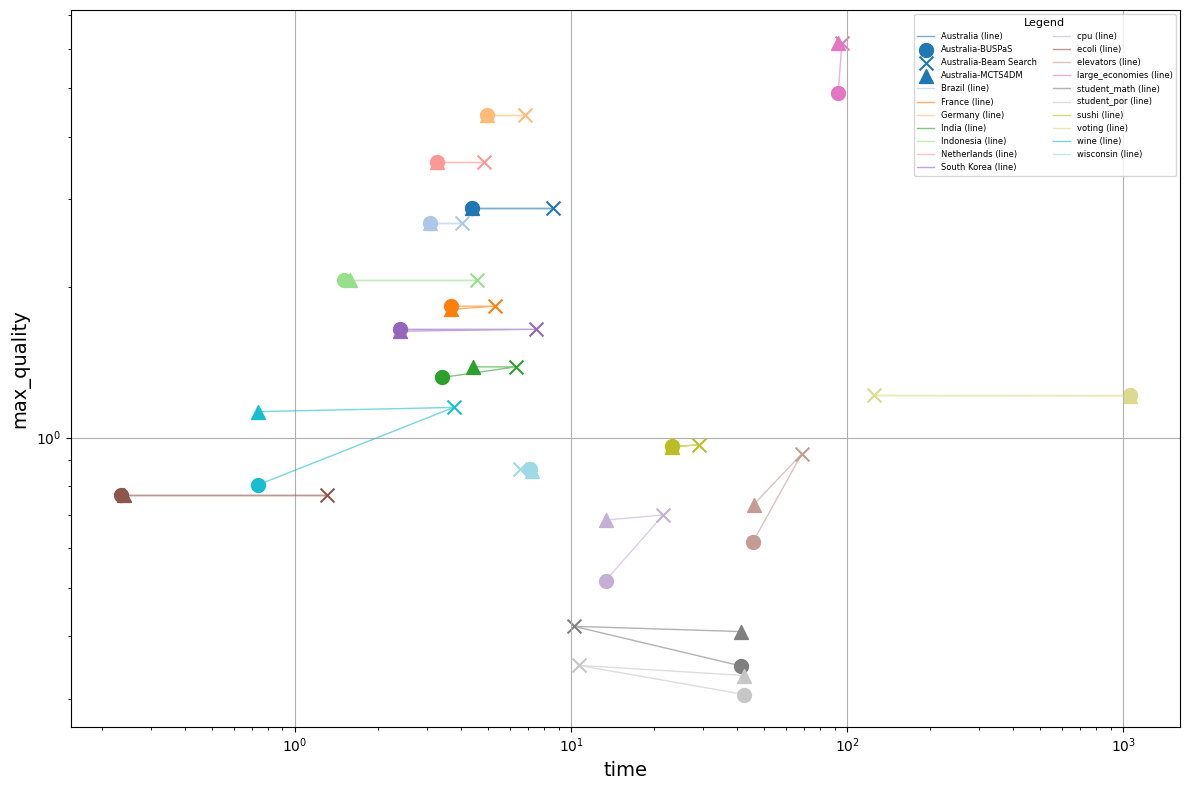

In [25]:
plot_pivot_tables_with_logscale(pivot_time, pivot_max_qual, log_scale=True,xaxis_label='time',yaxis_label='max_quality')

C:\Users\bengelen004\AppData\Local\Temp\ipykernel_16888\456662600.py:156: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_datasets)  # Use a colormap with enough distinct colors


Plot saved as SVG: ./E4 results/figures\plot_pivot_tables_time_diversity.svg
Plot saved as PDF: ./E4 results/figures\plot_pivot_tables_time_diversity.pdf


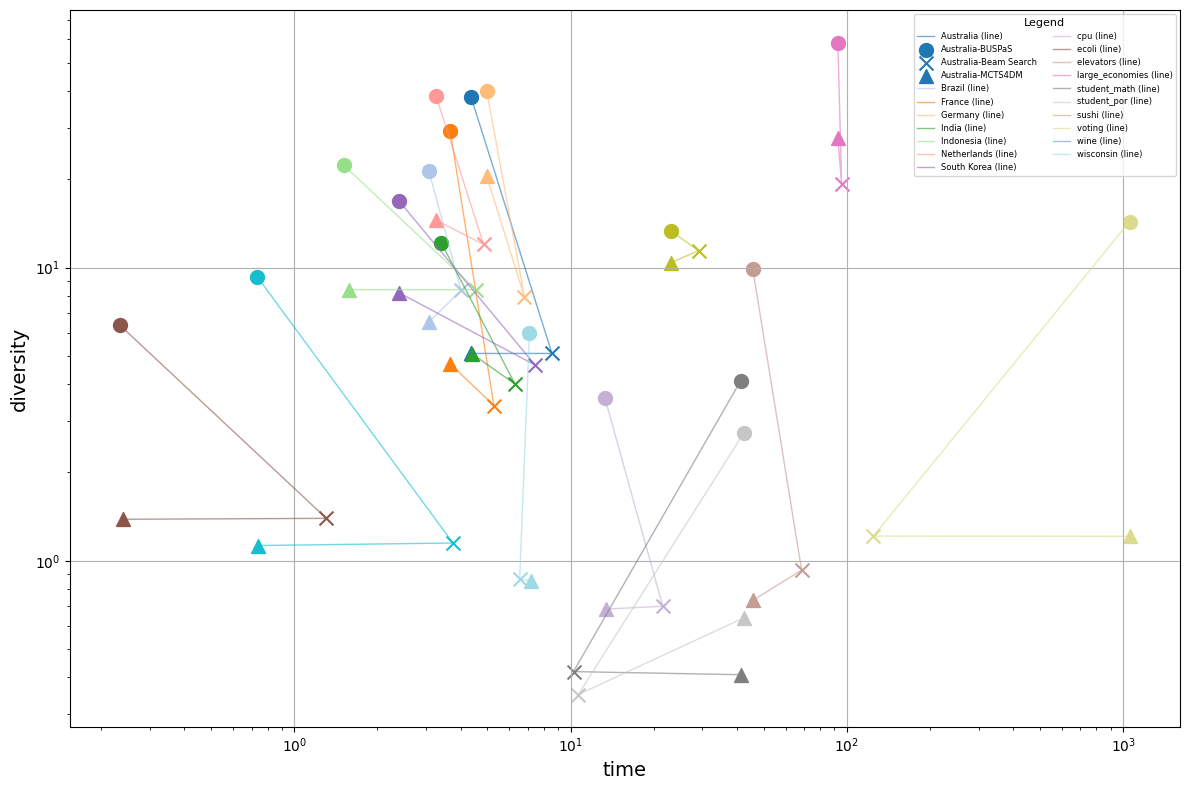

In [24]:
plot_pivot_tables_with_logscale(pivot_time, pivot_diversity, log_scale=True,xaxis_label='time',yaxis_label='diversity')